In [2]:
try :
  from google.colab import drive
  IN_COLAB = True
except:
  IN_COLAB = False
print('IN COLAB: ', IN_COLAB)

IN COLAB:  False


In [3]:
import os
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import uuid
import re
from torch import nn
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import json
from torch.utils.data import DataLoader, Dataset
from transformers import BertModel, BertTokenizer, BertForSequenceClassification
import torch
import numpy as np



In [4]:
parentdir = "./propaganda_dataset_v2"
train_file= "propaganda_train.tsv"
val_file= "propaganda_val.tsv"

train_path=os.path.join(parentdir,train_file)
val_path=os.path.join(parentdir,val_file)

if IN_COLAB:
  train_path = '/content/propaganda_train.tsv'
  val_path = '/content/propaganda_val.tsv'

train_df=pd.read_csv(train_path,delimiter="\t",quotechar='|')
val_df=pd.read_csv(val_path,delimiter="\t",quotechar='|')
train_df = train_df.drop(train_df[train_df['label'] == 'not_propaganda'].index)
val_df = val_df.drop(val_df[val_df['label'] == 'not_propaganda'].index)
train_df
val_df


,label,tagged_in_context
1,causal_oversimplification,Mostly because <BOS> the country would not las...
2,appeal_to_fear_prejudice,Lyndon Johnson <BOS> gets Earl Warren and Sen....
4,repetition,It must be exacted from him directly in order ...
5,"name_calling,labeling",Is it any wonder that priests and laity alike ...
6,loaded_language,Health workers have been asked to work with co...
...,...,...
629,flag_waving,"As a result, 58,177 <BOS> Americans <EOS> woul..."
631,flag_waving,<BOS> But if you are a freedom-loving American...
632,loaded_language,I heard lots of <BOS> gut-wrenching stories <E...
638,flag_waving,<BOS> He also sang an Islamic State fight song...


In [5]:
def extract_tagged_section(row):
    pattern = r'<BOS>.*?<EOS>'
    match = re.search(pattern, row['tagged_in_context'])
    return match.group() if match else ""

def extract_text_inside_tags(row):
    pattern = r'<BOS>(.*?)<EOS>'
    match = re.search(pattern, row['tagged_in_context'])
    return match.group(1).strip() if match else ""

def transform_multi_label(row):
    new_value = label_to_id[row['label']]
    return new_value

def transform_strip_tag(row):
    sent = row['tagged_in_context']
    cleaned_string = sent.replace("<BOS>", "")
    cleaned_string = cleaned_string.replace("<EOS>", "")
    return cleaned_string


label_to_id = {'flag_waving': 0, 'exaggeration,minimisation': 1, 'causal_oversimplification': 2, 'name_calling,labeling': 3, 'repetition': 4, 'doubt': 5, 'loaded_language': 6, 'appeal_to_fear_prejudice': 7}
id_to_label = {0: 'flag_waving', 1: 'exaggeration,minimisation', 2: 'causal_oversimplification', 3: 'name_calling,labeling', 4: 'repetition', 5: 'doubt',6: 'loaded_language', 7: 'appeal_to_fear_prejudice'}

train_df['label_str'] = train_df.apply(transform_multi_label, axis=1)
train_df['extract_no_tags'] = train_df.apply(extract_text_inside_tags, axis=1)
train_df['extract_with_tags'] = train_df.apply(extract_tagged_section, axis=1)

val_df['label_str'] = val_df.apply(transform_multi_label, axis=1)
val_df['extract_no_tags'] = val_df.apply(extract_text_inside_tags, axis=1)
val_df['extract_with_tags'] = val_df.apply(extract_tagged_section, axis=1)

val_df

,label,tagged_in_context,label_str,extract_no_tags,extract_with_tags
1,causal_oversimplification,Mostly because <BOS> the country would not las...,2,the country would not last long without an out...,<BOS> the country would not last long without ...
2,appeal_to_fear_prejudice,Lyndon Johnson <BOS> gets Earl Warren and Sen....,7,gets Earl Warren and Sen. Richard Russel to jo...,<BOS> gets Earl Warren and Sen. Richard Russel...
4,repetition,It must be exacted from him directly in order ...,4,infidels,<BOS> infidels <EOS>
5,"name_calling,labeling",Is it any wonder that priests and laity alike ...,3,"the ""gay lifestyle","<BOS> the ""gay lifestyle <EOS>"
6,loaded_language,Health workers have been asked to work with co...,6,devastating communities,<BOS> devastating communities <EOS>
...,...,...,...,...,...
629,flag_waving,"As a result, 58,177 <BOS> Americans <EOS> woul...",0,Americans,<BOS> Americans <EOS>
631,flag_waving,<BOS> But if you are a freedom-loving American...,0,But if you are a freedom-loving American,<BOS> But if you are a freedom-loving American...
632,loaded_language,I heard lots of <BOS> gut-wrenching stories <E...,6,gut-wrenching stories,<BOS> gut-wrenching stories <EOS>
638,flag_waving,<BOS> He also sang an Islamic State fight song...,0,He also sang an Islamic State fight song and r...,<BOS> He also sang an Islamic State fight song...


In [6]:
class CustomPropagandaDataset_vanilla(Dataset):
    def __init__(self,df, max_len, sent_col, target_col):
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

        self.labels=torch.tensor([label for label in df[target_col]])
        # print(self.labels)
        self.texts=[tokenizer(text,padding='max_length',max_length=max_len,truncation=True,return_tensors="pt") for text in df[sent_col]]
        # print(self.texts)
    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self,idx):
        return np.array(self.labels[idx])

    def get_batch_texts(self,idx):
        return self.texts[idx]

    def __getitem__(self,idx):
        batch_texts=self.get_batch_texts(idx)
        batch_y=self.get_batch_labels(idx)

        return batch_texts,batch_y


def prepare_inputs(input1,label,device):
  label=label.to(device)
  mask=input1['attention_mask'].to(device)
  input_id=input1['input_ids'].squeeze(1).to(device)
  return (input_id,mask,label)

In [7]:

class BertClassifier(nn.Module):

    def __init__(self,dropout=0.5,num_classes=8):
        super().__init__()

        self.bert=BertModel.from_pretrained('bert-base-uncased')
        self.dropout=nn.Dropout(dropout)
        self.linear=nn.Linear(768,num_classes)
        self.relu=nn.ReLU()

    def forward(self,input_id,mask):

        _, pooled_output = self.bert(input_ids=input_id,attention_mask=mask,return_dict=False)
        dropout_output=self.dropout(pooled_output)
        linear_output=self.linear(dropout_output)
        final_layer=self.relu(linear_output)

        return final_layer

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [9]:

# lrs = [1e-6, 5e-7, 1e-7]

lrs = [5e-4, 1e-4, 5e-5, 1e-5]
epochs = 20
bn=50
max_len=150
n_classes = 8
dr = 0.5


for lr in lrs:
  sent_col = 'extract_no_tags'
  target_col = 'label_str'
  
  train_data = CustomPropagandaDataset_vanilla(train_df, max_len, sent_col, target_col)
  val_data = CustomPropagandaDataset_vanilla(val_df, max_len, sent_col, target_col)
  
  train_dataloader=torch.utils.data.DataLoader(train_data,batch_size=bn,shuffle=True)
  val_dataloader=torch.utils.data.DataLoader(val_data,batch_size=bn)
    
    
  model=BertClassifier(num_classes=8)
  criterion=nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)


  train_acc_list = []
  train_loss_list = []
  val_acc_list = []
  val_loss_list = []

  best_val_acc = 0
  best_epoch = 0
  best_model_state = None

  model_id = str(uuid.uuid4())


  model.to(device)
  for epoch_num in range(epochs):
          total_acc_train=0
          total_loss_train=0
          model.train()
          for train_input,train_label in tqdm(train_dataloader):

              input_id,mask, train_label=prepare_inputs(train_input,train_label,device)

              output_1=model(input_id,mask)

              batch_loss_1=criterion(output_1,train_label.long())
              total_loss_train +=batch_loss_1.item()

              acc=(output_1.argmax(dim=1)==train_label).sum().item()
              total_acc_train+=acc

              model.zero_grad()
              batch_loss_1.backward()
              optimizer.step()

          total_acc_val=0
          total_loss_val=0

          y_true = []
          y_pred = []
          model.eval()
          with torch.no_grad():
              for val_input,val_label in val_dataloader:

                  input_id,mask, val_label=prepare_inputs(val_input,val_label,device)

                  output_2= model(input_id,mask)

                  # for scoring
                  predicted = output_2.argmax(dim=1)
                  y_true.extend(val_label.cpu().numpy())
                  y_pred.extend(predicted.cpu().numpy())

                  batch_loss_2=criterion(output_2,val_label.long())

                  total_loss_val+=batch_loss_2.item()

                  acc=(output_2.argmax(dim=1)==val_label).sum().item()
                  total_acc_val+=acc
              train_acc = total_acc_train / len(train_data)

          train_loss = total_loss_train / len(train_data)
          val_acc = total_acc_val / len(val_data)
          val_loss = total_loss_val / len(val_data)

          train_acc_list.append(train_acc)
          train_loss_list.append(train_loss)
          val_acc_list.append(val_acc)
          val_loss_list.append(val_loss)

          print(f'Epochs: {epoch_num+1} | Train Loss: {total_loss_train / len(train_data):.3f} | Train Accuracy: {total_acc_train/len(train_data):.3f}')
          print(f'Val loss: {total_loss_val/len(val_data):.3f} | Val Accuracy: {total_acc_val / len(val_data):.3f}')
          if val_acc > best_val_acc:
            best_epoch = epoch_num
            y_true_best = y_true.copy()
            y_pred_best = y_pred.copy()
            best_val_acc = val_acc
            best_model_state = model.state_dict()

          if epoch_num == epochs-1:
              print(f'______{model_id}______')
              print(f'LR: {lr} FINAL ACC = {total_acc_val / len(val_data):.3f}')
              print(f'LR: {lr} BEST ACC = {best_val_acc:.3f}')
              print('____________')


  # Plot the accuracy and loss curves over epochs
  epochs_range = range(1, epochs+1)

  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, train_acc_list, label='Training Accuracy')
  plt.plot(epochs_range, val_acc_list, label='Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.title('Accuracy Curves')

#   plt.subplot(1, 2, 2)
#   plt.plot(epochs_range, train_loss_list, label='Training Loss')
#   plt.plot(epochs_range, val_loss_list, label='Validation Loss')
#   plt.xlabel('Epochs')
#   plt.ylabel('Loss')
#   plt.legend(loc='upper right')
#   plt.title('Loss Curves')
  plt.title(f'Accuracy for lr {lr}, batch size {bn}, best ac: {best_val_acc:.2f}')

  plt.tight_layout()
  plt.show()

  # analysis of best performing model
  classes = list(id_to_label.values())
  cm = confusion_matrix(y_true_best, y_pred_best)

  disp = ConfusionMatrixDisplay(cm)
  disp.plot()

  # Compute precision, recall, F1-score, and other metrics for the best model
  report = classification_report(y_true_best, y_pred_best, target_names=classes)
  print('Classification Report:')
  print(report)


  results_dict = {
      'model_id': model_id,
      'train_accuracy': train_acc_list,
      'train_loss': train_loss_list,
      'val_accuracy': val_acc_list,
      'val_loss': val_loss_list,
      'hyperparameters': {
          'learning_rate': lr,
          'num_epochs': epochs,
          'batch_size': bn,
          'max_len': max_len,
          'dropout': dr

      },
      'results': {
          "classes": n_classes,
          "last_acc": val_acc_list[-1],
          'best_acc': best_val_acc,
          'best_acc_epoch': best_epoch,
          'confusion_matrix': cm.tolist(),
          'classification_report': report
      }
  }


  # Save the results dictionary as a JSON file with the model ID
  results_filename = f'./results/multiclass_results_{model_id}.json'
  with open(results_filename, 'w') as f:
      json.dump(results_dict, f, indent=4)


100%|██████████| 26/26 [00:14<00:00,  1.78it/s]


Epochs: 1 | Train Loss: 0.042 | Train Accuracy: 0.118
Val loss: 0.047 | Val Accuracy: 0.146


100%|██████████| 26/26 [00:14<00:00,  1.82it/s]


Epochs: 2 | Train Loss: 0.042 | Train Accuracy: 0.119
Val loss: 0.047 | Val Accuracy: 0.146


 35%|███▍      | 9/26 [00:05<00:10,  1.57it/s]


KeyboardInterrupt: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 52/52 [00:16<00:00,  3.14it/s]


Epochs: 1 | Train Loss: 0.086 | Train Accuracy: 0.136
Val loss: 0.089 | Val Accuracy: 0.149


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 2 | Train Loss: 0.084 | Train Accuracy: 0.161
Val loss: 0.088 | Val Accuracy: 0.152


100%|██████████| 52/52 [00:15<00:00,  3.25it/s]


Epochs: 3 | Train Loss: 0.083 | Train Accuracy: 0.192
Val loss: 0.086 | Val Accuracy: 0.204


100%|██████████| 52/52 [00:16<00:00,  3.24it/s]


Epochs: 4 | Train Loss: 0.081 | Train Accuracy: 0.249
Val loss: 0.084 | Val Accuracy: 0.252


100%|██████████| 52/52 [00:16<00:00,  3.24it/s]


Epochs: 5 | Train Loss: 0.080 | Train Accuracy: 0.260
Val loss: 0.083 | Val Accuracy: 0.256


100%|██████████| 52/52 [00:16<00:00,  3.23it/s]


Epochs: 6 | Train Loss: 0.079 | Train Accuracy: 0.269
Val loss: 0.082 | Val Accuracy: 0.262


100%|██████████| 52/52 [00:16<00:00,  3.23it/s]


Epochs: 7 | Train Loss: 0.078 | Train Accuracy: 0.289
Val loss: 0.081 | Val Accuracy: 0.252


100%|██████████| 52/52 [00:16<00:00,  3.23it/s]


Epochs: 8 | Train Loss: 0.076 | Train Accuracy: 0.317
Val loss: 0.080 | Val Accuracy: 0.275


100%|██████████| 52/52 [00:16<00:00,  3.24it/s]


Epochs: 9 | Train Loss: 0.075 | Train Accuracy: 0.333
Val loss: 0.078 | Val Accuracy: 0.275


100%|██████████| 52/52 [00:16<00:00,  3.24it/s]


Epochs: 10 | Train Loss: 0.074 | Train Accuracy: 0.332
Val loss: 0.078 | Val Accuracy: 0.291


100%|██████████| 52/52 [00:16<00:00,  3.24it/s]


Epochs: 11 | Train Loss: 0.073 | Train Accuracy: 0.377
Val loss: 0.077 | Val Accuracy: 0.301


100%|██████████| 52/52 [00:16<00:00,  3.24it/s]


Epochs: 12 | Train Loss: 0.072 | Train Accuracy: 0.374
Val loss: 0.076 | Val Accuracy: 0.294


100%|██████████| 52/52 [00:16<00:00,  3.24it/s]


Epochs: 13 | Train Loss: 0.071 | Train Accuracy: 0.380
Val loss: 0.075 | Val Accuracy: 0.291


100%|██████████| 52/52 [00:16<00:00,  3.24it/s]


Epochs: 14 | Train Loss: 0.070 | Train Accuracy: 0.412
Val loss: 0.074 | Val Accuracy: 0.304


100%|██████████| 52/52 [00:16<00:00,  3.25it/s]


Epochs: 15 | Train Loss: 0.068 | Train Accuracy: 0.414
Val loss: 0.073 | Val Accuracy: 0.317


100%|██████████| 52/52 [00:15<00:00,  3.25it/s]


Epochs: 16 | Train Loss: 0.067 | Train Accuracy: 0.435
Val loss: 0.073 | Val Accuracy: 0.330


100%|██████████| 52/52 [00:16<00:00,  3.25it/s]


Epochs: 17 | Train Loss: 0.067 | Train Accuracy: 0.428
Val loss: 0.072 | Val Accuracy: 0.337


100%|██████████| 52/52 [00:15<00:00,  3.25it/s]


Epochs: 18 | Train Loss: 0.066 | Train Accuracy: 0.449
Val loss: 0.071 | Val Accuracy: 0.350


100%|██████████| 52/52 [00:15<00:00,  3.25it/s]


Epochs: 19 | Train Loss: 0.065 | Train Accuracy: 0.471
Val loss: 0.071 | Val Accuracy: 0.366


100%|██████████| 52/52 [00:15<00:00,  3.25it/s]


Epochs: 20 | Train Loss: 0.064 | Train Accuracy: 0.477
Val loss: 0.070 | Val Accuracy: 0.359


100%|██████████| 52/52 [00:16<00:00,  3.19it/s]


Epochs: 21 | Train Loss: 0.063 | Train Accuracy: 0.486
Val loss: 0.069 | Val Accuracy: 0.369


100%|██████████| 52/52 [00:16<00:00,  3.07it/s]


Epochs: 22 | Train Loss: 0.062 | Train Accuracy: 0.482
Val loss: 0.069 | Val Accuracy: 0.375


100%|██████████| 52/52 [00:17<00:00,  3.04it/s]


Epochs: 23 | Train Loss: 0.061 | Train Accuracy: 0.515
Val loss: 0.068 | Val Accuracy: 0.388


100%|██████████| 52/52 [00:16<00:00,  3.08it/s]


Epochs: 24 | Train Loss: 0.060 | Train Accuracy: 0.524
Val loss: 0.068 | Val Accuracy: 0.395


100%|██████████| 52/52 [00:16<00:00,  3.08it/s]


Epochs: 25 | Train Loss: 0.059 | Train Accuracy: 0.550
Val loss: 0.067 | Val Accuracy: 0.398


100%|██████████| 52/52 [00:16<00:00,  3.08it/s]


Epochs: 26 | Train Loss: 0.058 | Train Accuracy: 0.568
Val loss: 0.066 | Val Accuracy: 0.417


100%|██████████| 52/52 [00:16<00:00,  3.08it/s]


Epochs: 27 | Train Loss: 0.057 | Train Accuracy: 0.579
Val loss: 0.066 | Val Accuracy: 0.427


100%|██████████| 52/52 [00:16<00:00,  3.06it/s]


Epochs: 28 | Train Loss: 0.056 | Train Accuracy: 0.594
Val loss: 0.065 | Val Accuracy: 0.427


100%|██████████| 52/52 [00:16<00:00,  3.07it/s]


Epochs: 29 | Train Loss: 0.055 | Train Accuracy: 0.596
Val loss: 0.064 | Val Accuracy: 0.450


100%|██████████| 52/52 [00:17<00:00,  3.05it/s]


Epochs: 30 | Train Loss: 0.055 | Train Accuracy: 0.610
Val loss: 0.064 | Val Accuracy: 0.447


100%|██████████| 52/52 [00:16<00:00,  3.08it/s]


Epochs: 31 | Train Loss: 0.054 | Train Accuracy: 0.629
Val loss: 0.063 | Val Accuracy: 0.469


100%|██████████| 52/52 [00:16<00:00,  3.07it/s]


Epochs: 32 | Train Loss: 0.053 | Train Accuracy: 0.644
Val loss: 0.062 | Val Accuracy: 0.466


100%|██████████| 52/52 [00:16<00:00,  3.07it/s]


Epochs: 33 | Train Loss: 0.051 | Train Accuracy: 0.648
Val loss: 0.061 | Val Accuracy: 0.469


100%|██████████| 52/52 [00:17<00:00,  3.05it/s]


Epochs: 34 | Train Loss: 0.051 | Train Accuracy: 0.666
Val loss: 0.061 | Val Accuracy: 0.485


100%|██████████| 52/52 [00:16<00:00,  3.07it/s]


Epochs: 35 | Train Loss: 0.050 | Train Accuracy: 0.669
Val loss: 0.060 | Val Accuracy: 0.495


100%|██████████| 52/52 [00:17<00:00,  3.05it/s]


Epochs: 36 | Train Loss: 0.049 | Train Accuracy: 0.682
Val loss: 0.059 | Val Accuracy: 0.485


100%|██████████| 52/52 [00:16<00:00,  3.07it/s]


Epochs: 37 | Train Loss: 0.048 | Train Accuracy: 0.692
Val loss: 0.059 | Val Accuracy: 0.495


100%|██████████| 52/52 [00:17<00:00,  3.05it/s]


Epochs: 38 | Train Loss: 0.047 | Train Accuracy: 0.718
Val loss: 0.058 | Val Accuracy: 0.508


100%|██████████| 52/52 [00:16<00:00,  3.07it/s]


Epochs: 39 | Train Loss: 0.046 | Train Accuracy: 0.719
Val loss: 0.058 | Val Accuracy: 0.515


100%|██████████| 52/52 [00:16<00:00,  3.07it/s]


Epochs: 40 | Train Loss: 0.045 | Train Accuracy: 0.732
Val loss: 0.057 | Val Accuracy: 0.524


100%|██████████| 52/52 [00:16<00:00,  3.08it/s]


Epochs: 41 | Train Loss: 0.044 | Train Accuracy: 0.743
Val loss: 0.056 | Val Accuracy: 0.534


100%|██████████| 52/52 [00:17<00:00,  3.06it/s]


Epochs: 42 | Train Loss: 0.043 | Train Accuracy: 0.769
Val loss: 0.056 | Val Accuracy: 0.544


100%|██████████| 52/52 [00:16<00:00,  3.08it/s]


Epochs: 43 | Train Loss: 0.042 | Train Accuracy: 0.750
Val loss: 0.055 | Val Accuracy: 0.557


100%|██████████| 52/52 [00:16<00:00,  3.08it/s]


Epochs: 44 | Train Loss: 0.041 | Train Accuracy: 0.764
Val loss: 0.055 | Val Accuracy: 0.557


100%|██████████| 52/52 [00:16<00:00,  3.07it/s]


Epochs: 45 | Train Loss: 0.040 | Train Accuracy: 0.775
Val loss: 0.054 | Val Accuracy: 0.557


100%|██████████| 52/52 [00:16<00:00,  3.08it/s]


Epochs: 46 | Train Loss: 0.040 | Train Accuracy: 0.771
Val loss: 0.054 | Val Accuracy: 0.553


100%|██████████| 52/52 [00:16<00:00,  3.08it/s]


Epochs: 47 | Train Loss: 0.038 | Train Accuracy: 0.792
Val loss: 0.053 | Val Accuracy: 0.557


100%|██████████| 52/52 [00:17<00:00,  3.05it/s]


Epochs: 48 | Train Loss: 0.038 | Train Accuracy: 0.799
Val loss: 0.053 | Val Accuracy: 0.579


100%|██████████| 52/52 [00:16<00:00,  3.07it/s]


Epochs: 49 | Train Loss: 0.037 | Train Accuracy: 0.805
Val loss: 0.052 | Val Accuracy: 0.579


100%|██████████| 52/52 [00:17<00:00,  3.05it/s]


Epochs: 50 | Train Loss: 0.036 | Train Accuracy: 0.793
Val loss: 0.052 | Val Accuracy: 0.579


100%|██████████| 52/52 [00:16<00:00,  3.07it/s]


Epochs: 51 | Train Loss: 0.035 | Train Accuracy: 0.817
Val loss: 0.052 | Val Accuracy: 0.576


100%|██████████| 52/52 [00:17<00:00,  3.05it/s]


Epochs: 52 | Train Loss: 0.035 | Train Accuracy: 0.819
Val loss: 0.051 | Val Accuracy: 0.589


100%|██████████| 52/52 [00:17<00:00,  3.05it/s]


Epochs: 53 | Train Loss: 0.034 | Train Accuracy: 0.816
Val loss: 0.051 | Val Accuracy: 0.589


100%|██████████| 52/52 [00:17<00:00,  3.05it/s]


Epochs: 54 | Train Loss: 0.032 | Train Accuracy: 0.841
Val loss: 0.050 | Val Accuracy: 0.586


100%|██████████| 52/52 [00:17<00:00,  3.05it/s]


Epochs: 55 | Train Loss: 0.032 | Train Accuracy: 0.846
Val loss: 0.050 | Val Accuracy: 0.605


100%|██████████| 52/52 [00:17<00:00,  3.06it/s]


Epochs: 56 | Train Loss: 0.031 | Train Accuracy: 0.847
Val loss: 0.050 | Val Accuracy: 0.605


100%|██████████| 52/52 [00:16<00:00,  3.06it/s]


Epochs: 57 | Train Loss: 0.031 | Train Accuracy: 0.848
Val loss: 0.050 | Val Accuracy: 0.595


100%|██████████| 52/52 [00:17<00:00,  3.05it/s]


Epochs: 58 | Train Loss: 0.029 | Train Accuracy: 0.854
Val loss: 0.049 | Val Accuracy: 0.599


100%|██████████| 52/52 [00:17<00:00,  3.06it/s]


Epochs: 59 | Train Loss: 0.029 | Train Accuracy: 0.859
Val loss: 0.049 | Val Accuracy: 0.605


100%|██████████| 52/52 [00:17<00:00,  3.05it/s]


Epochs: 60 | Train Loss: 0.028 | Train Accuracy: 0.866
Val loss: 0.049 | Val Accuracy: 0.599
______e0fab39b-7665-46a6-9a8b-9fb3607a780f______
LR: 1e-06 FINAL ACC = 0.599
LR: 1e-06 BEST ACC = 0.605
____________


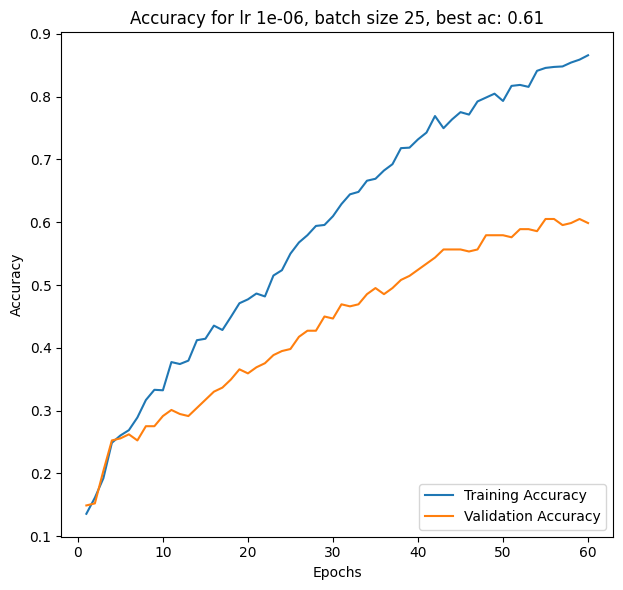

Classification Report:
                           precision    recall  f1-score   support

              flag_waving       0.82      0.69      0.75        45
exaggeration,minimisation       0.48      0.53      0.51        30
causal_oversimplification       0.61      0.63      0.62        35
    name_calling,labeling       0.76      0.74      0.75        34
               repetition       0.53      0.42      0.47        40
                    doubt       0.62      0.60      0.61        43
          loaded_language       0.51      0.59      0.55        39
 appeal_to_fear_prejudice       0.54      0.63      0.58        43

                 accuracy                           0.61       309
                macro avg       0.61      0.60      0.60       309
             weighted avg       0.61      0.61      0.61       309



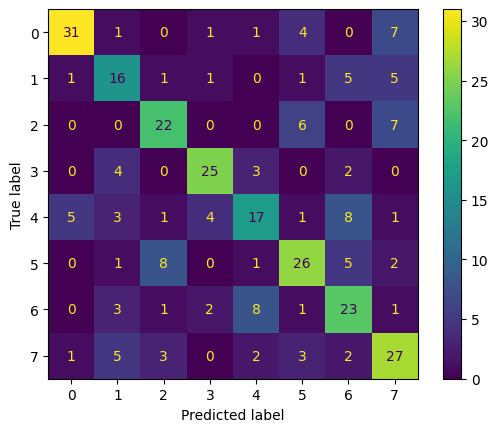

In [11]:
# BERT4Sequence
epochs = 60
lr = 1e-6
bn=25
max_len=150
n_classes = 8
dr = 0.5


for lr in [0.000001]:
    sent_col = 'extract_no_tags'
    target_col = 'label_str'
    
    train_data = CustomPropagandaDataset_vanilla(train_df, max_len, sent_col, target_col)
    val_data = CustomPropagandaDataset_vanilla(val_df, max_len, sent_col, target_col)
    
    train_dataloader=torch.utils.data.DataLoader(train_data,batch_size=bn,shuffle=True)
    val_dataloader=torch.utils.data.DataLoader(val_data,batch_size=bn)
        
        
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=n_classes).to(device)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)


    train_acc_list = []
    train_loss_list = []
    val_acc_list = []
    val_loss_list = []

    best_val_acc = 0
    best_epoch = 0
    best_model_state = None

    model_id = str(uuid.uuid4())


    for epoch_num in range(epochs):


            total_acc_train=0
            total_loss_train=0
            model.train()

            for train_input,train_label in tqdm(train_dataloader):

                input_id,mask, train_label=prepare_inputs(train_input,train_label,device)

                output_1=model(input_id,mask, labels=train_label)

                batch_loss_1=output_1.loss

                total_loss_train += batch_loss_1.item()

                acc=(output_1.logits.argmax(dim=1)==train_label).sum().item()
                total_acc_train+=acc

                model.zero_grad()
                batch_loss_1.backward()
                optimizer.step()

            total_acc_val=0
            total_loss_val=0

            y_true = []
            y_pred = []
            model.eval()
            with torch.no_grad():
                for val_input,val_label in val_dataloader:

                    input_id,mask, val_label=prepare_inputs(val_input,val_label,device)

                    output_2= model(input_id,mask, labels=val_label)

                    # for scoring
                    predicted = output_2.logits.argmax(dim=1)
                    y_true.extend(val_label.cpu().numpy())
                    y_pred.extend(predicted.cpu().numpy())

                    # batch_loss_2=criterion(output_2,val_label.long())
                    batch_loss_2=output_2.loss

                    total_loss_val+=batch_loss_2.item()

                    acc=(output_2.logits.argmax(dim=1)==val_label).sum().item()
                    total_acc_val+=acc
            
            train_acc = total_acc_train / len(train_data)
            train_loss = total_loss_train / len(train_data)
            val_acc = total_acc_val / len(val_data)
            val_loss = total_loss_val / len(val_data)

            train_acc_list.append(train_acc)
            train_loss_list.append(train_loss)
            val_acc_list.append(val_acc)
            val_loss_list.append(val_loss)

            print(f'Epochs: {epoch_num+1} | Train Loss: {total_loss_train / len(train_data):.3f} | Train Accuracy: {total_acc_train/len(train_data):.3f}')
            print(f'Val loss: {total_loss_val/len(val_data):.3f} | Val Accuracy: {total_acc_val / len(val_data):.3f}')
            if val_acc > best_val_acc:
                best_epoch = epoch_num
                y_true_best = y_true.copy()
                y_pred_best = y_pred.copy()
                best_val_acc = val_acc
                best_model_state = model.state_dict()

            if epoch_num == epochs-1:
                print(f'______{model_id}______')
                print(f'LR: {lr} FINAL ACC = {total_acc_val / len(val_data):.3f}')
                print(f'LR: {lr} BEST ACC = {best_val_acc:.3f}')
                print('____________')
                
    # Plot the accuracy and loss curves over epochs
    epochs_range = range(1, epochs+1)
  
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_acc_list, label='Training Accuracy')
    plt.plot(epochs_range, val_acc_list, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title('Accuracy Curves')
  
  #   plt.subplot(1, 2, 2)
  #   plt.plot(epochs_range, train_loss_list, label='Training Loss')
  #   plt.plot(epochs_range, val_loss_list, label='Validation Loss')
  #   plt.xlabel('Epochs')
  #   plt.ylabel('Loss')
  #   plt.legend(loc='upper right')
  #   plt.title('Loss Curves')
    plt.title(f'Accuracy for lr {lr}, batch size {bn}, best ac: {best_val_acc:.2f}')
  
    plt.tight_layout()
    plt.show()
  
    # analysis of best performing model
    classes = list(id_to_label.values())
    cm = confusion_matrix(y_true_best, y_pred_best)
  
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
  
    # Compute precision, recall, F1-score, and other metrics for the best model
    report = classification_report(y_true_best, y_pred_best, target_names=classes)
    print('Classification Report:')
    print(report)
  
  
    results_dict = {
        'model_id': model_id,
        'train_accuracy': train_acc_list,
        'train_loss': train_loss_list,
        'val_accuracy': val_acc_list,
        'val_loss': val_loss_list,
        'hyperparameters': {
            'learning_rate': lr,
            'num_epochs': epochs,
            'batch_size': bn,
            'max_len': max_len,
            'dropout': dr
  
        },
        'results': {
            "classes": n_classes,
            "last_acc": val_acc_list[-1],
            'best_acc': best_val_acc,
            'best_acc_epoch': best_epoch,
            'confusion_matrix': cm.tolist(),
            'classification_report': report
        }
    }
    # Save the results dictionary as a JSON file with the model ID
    results_filename = f'./results/bert4seq_multiclass_results_{model_id}.json'
    with open(results_filename, 'w') as f:
        json.dump(results_dict, f, indent=4)
  

